# IFT3700 Devoir 2

## Question 1 (30%)

Imaginez que vous devez traiter des données de nature astronomique. Il s’agit de données sous forme de table concernant 7300 milliards d’étoiles. 

Pour chaque étoile la table contient la position dans l’espace 3D (3 FLOAT64), la luminosité apparente de l’étoile (1 FLOAT32) et sa catégorie représentée par un entier entre 1 et 10 (1 INT8) et un vecteurs de 23 caractéristiques physiques (23 FLOAT32). La taille des données qui sont stockées de façon efficace dépasse le 900 Téraoctets. 

Les données sont réparties de façon balancée sur 1200 serveurs avec un  processeur rapide, 128 Gigaoctets de mémoire vive et utilisant chacun un disque SSD de capacité 4 Téraoctets et de vitesse de lecture et écriture de 3 Gigaoctets/sec. La communication entre les serveurs s'effectue à une vitesse de 1 Gigaoctets/sec. 


Proposez une approche distribuée qui permet de répondre aux questions suivantes et expliquez en détail toute la démarche permettant leur résolution.

### **A.** Trouvez les 1000 paires d’étoiles les plus proches en termes de distance euclidienne.[Recherche des deux points les plus rapprochés](https://fr.wikipedia.org/wiki/Recherche_des_deux_points_les_plus_rapproch%C3%A9s) (à nettoyer) 


[indice pour plus tard](https://sites.cs.ucsb.edu/~suri/cs235/ClosestPair.pdf) 

### Tri  ?

Avant de proposer un algorithme, essayons de trouver un moyen efficace de résoudre ce problème. 

Pour une visualistion simple, représentons à quoi peut ressembler un serveur qui contient des données sur les étoiles. Pour être plus précis représentons les étoiles contenu dans le serveur à travers un espace 3D:  
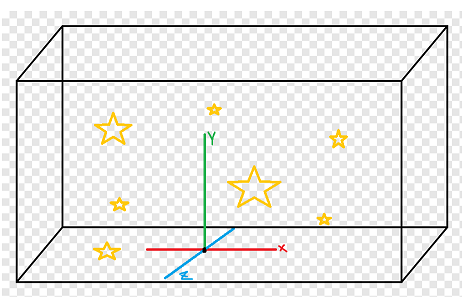

Pour le moment, oublions les autres serveurs et concentrons nous sur un seul uniquement. Une question se pose alors. Est-ce que les étoiles (Leurs positions dans l'espace 3D (x,y,z) pour être plus précis) sont triées dans l'ordre. Si oui, alors une partie du travail est faite. Puisque ce n'est pas précisé, nous allons assumer que non.

Nous n'allons pas proposer d'algorithme de tri détaillé, puisque ce n'est pas pertinant. Tous les serveurs peuvent trier leurs étoiles parallèlement en **T(n) = O(n log(n))**, ce qui correspondant au temps que peut prendre [les meilleurs algorithmes de tri](https://fr.wikipedia.org/wiki/Algorithme_de_tri). Cela dit, la raison pour laquelle nous allons pas proposer d'algorithme de tri est que nous n'allons pas trier de cette manière lors dans notre algorithme final. Pour le moment, nous voulions simplement démontrer un algorithme qui retourne les paires d'étoiles les plus proches d'un seul serveur. Puisque plus tard, nous allons prendre en comptes tous les serveurs, nous allons trier les choses différement. Bref, pour le moment, gardons en tête qu'on travaille sur un serveur qui est magiquement trié afin de se concentrer sur l'algorithme qui retourne les paires d'étoiles les plus proches. 

À noter qu'un serveur a une capacité de 4Téra, mais que seulement occupe cette capacitée soit 18,75% est occupée.
<br> Le calcul est comme suit : *( ( 900 Tera * 1000) GO / 1200 Serveurs)*. Cela fait que notre tri en parrallèle va bien se passer puisque nous pouvions déplacer nos étoiles dans le serveur sans aucun problème. 




### Divide and conquer

Assumons pour le moment que tout s'est bien passé et que nous avions trié avec succès nos étoiles dans un ordre croissant. Il est maintenant plus simple dans un serveur d'utiliser un algorthime [divide and conquer](https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm). Pourquoi ce type d'algorithme ? C'est pour séparer le gros problème en plus petits sous-problème et tous les résoudres parallèlement pour enfin avoir une réponse finale à notre gros problème. 

Dans notre cas, la solution brute aurait été de comparer chaque étoile à toutes les autres étoiles O(n^2) pour trouver les distances les plus courtes (soit les paires les plus proches). Ce qui est inconcevable vu la taille de notre échantillon. Donc , si on dévise efficacement notre problème, on peut réduire le O(n^2) jusqu'à O(n log n) , ce qui est beaucoup mieux. Nous allons maintenant expliquer comment procéder.

Encore une fois, pour un but d'illustration, travaillons pour le moment sur un seul serveur. Comment un serveur peut-t-il s'y prendre pour retourner la paire d'étoiles les plus proches ? Car oui, pour le moment essayons d'abord de trouver la paire d'étoiles la plus proches avant d'essayer d'en trouver 1000. 

On pourrait croire que la division de l'espace récursive dans l'approche que nous allons proposer va saturer la mémoire vive vu l'immense taille de notre échantillon. Cela dit, il n'y pas de risque puisque nous allons garder en mémoire seulement les plans qui séparent l'espace et les paires d'étoiles les plus intéressantes. Le reste au besoin , nous allons directement le lire dans le disque dur. 


Par la division de l'espace avec des plans, nous sous-entendons tout simplement créer un plan qui sépare l'espace 3D comme suit: 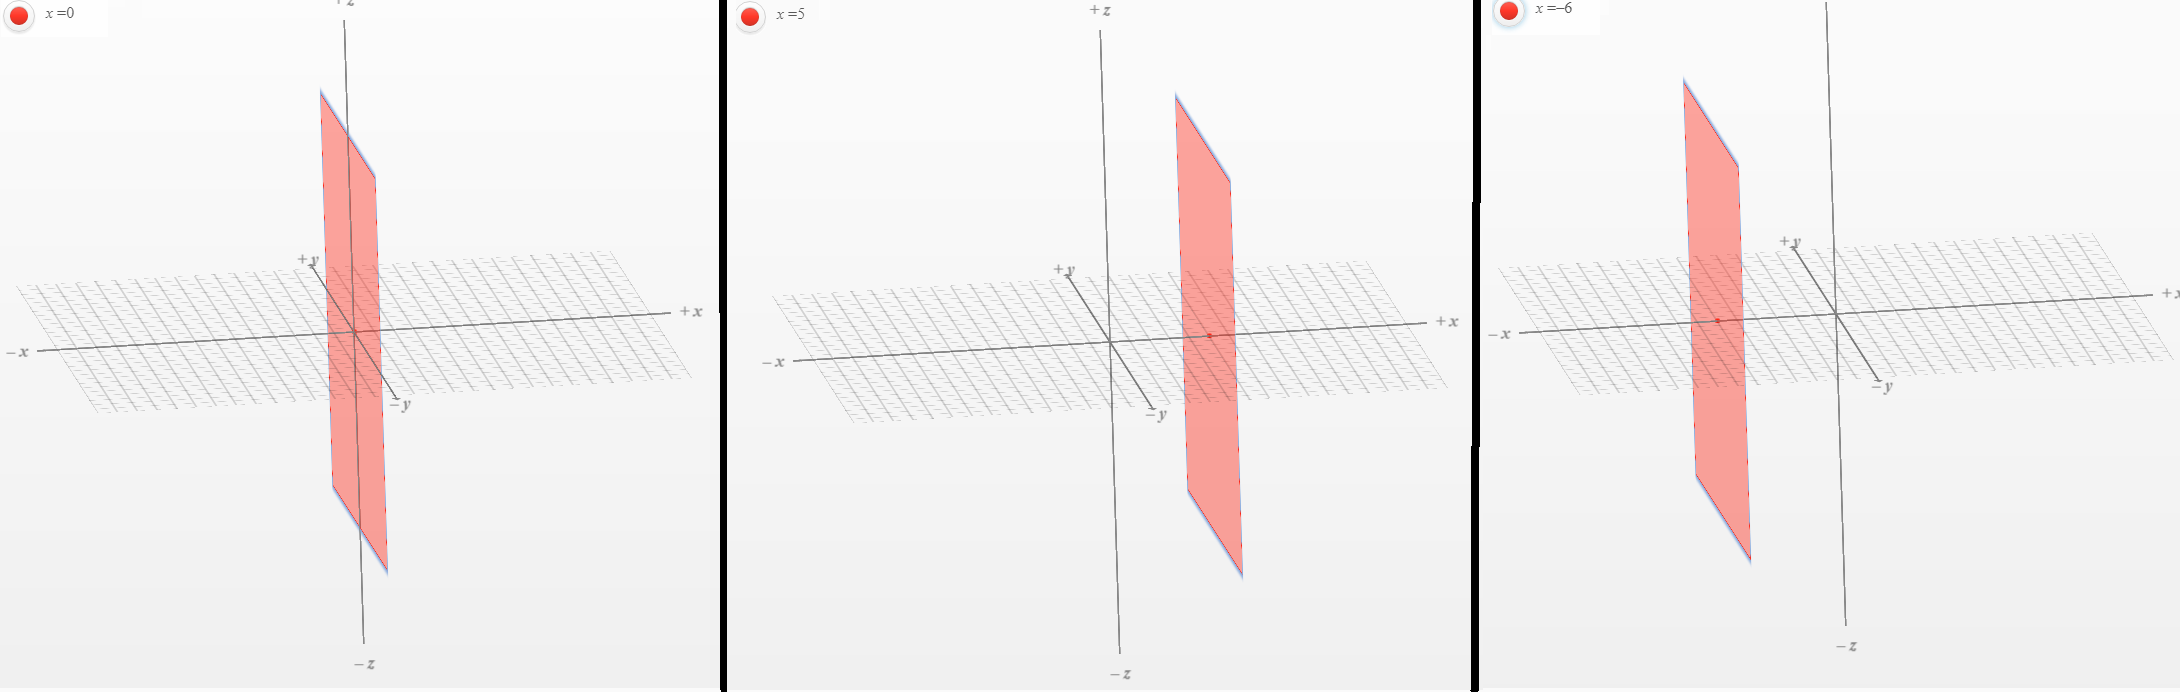 


Ainsi, nous pouvions proposer une première approche [indice](https://youtu.be/ldHA8UcQI9Q) :


**TrouverPaire** ( V : [VecteursPositionsÉtoiles_Trié] ) : 

    
    1. int D <- ( V[premier Element].getX + V[dernier Element].getX ) / 2 (Possible de deviser mieux qu'au milieu?) 
    
    2. plane <- x = D  
    
    3. Déviser V selon plane
    
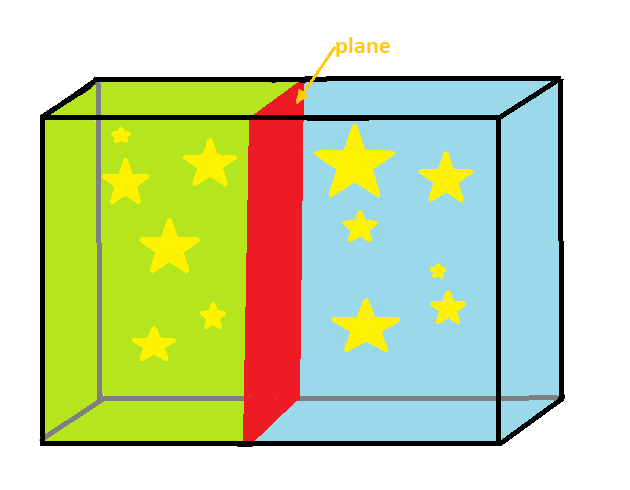
    

    B -> Case de base : return paire plus proche (distance euclidienne)  points des deux-sous plans 
    
    R -> Récursivement deviser les deux sous-espaces. 
    
    
Biensûre , il est important de noter que : Si S est la distance de la paire d'étoiles les plus proches dans le premier sous-espace et S' la distance de la paire la plus proches du deuxième sous-espace, alors return min(S , S') n'est pas suffisant.
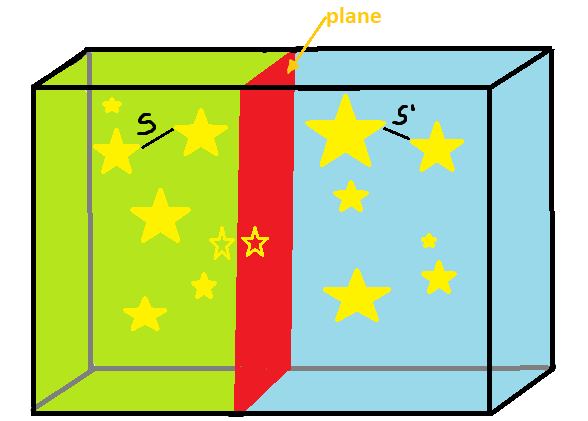 


En effet, il est possible qu'une étoile (p) du premier sous-espace et une étoile (d) du deuxième souce-espace forme une paire avec une distance S'' inférieure à min(S , S') . Autrement dit distance(p,d) = S'' et S'' < min(S, S').  
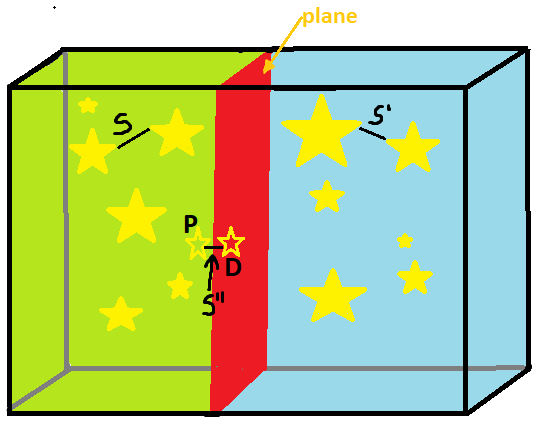


Comment faire pour trouver cette paire si elle existe ? Comparer chacunes des étoiles du premier sous-espace aux étoiles du deuxième sous-espace nous rammène à notre problème initiale (Brute Force O(n^2)). Heureusement , nous n'avions pas à le faire puisque que la distance S'' doit être plus petite que min(S, S'). Donc, puisque nous avions préablement trié notre espace, nous avions à regarder seulement à une distance de min(S, S') du plane. Illustrons nos propos : 

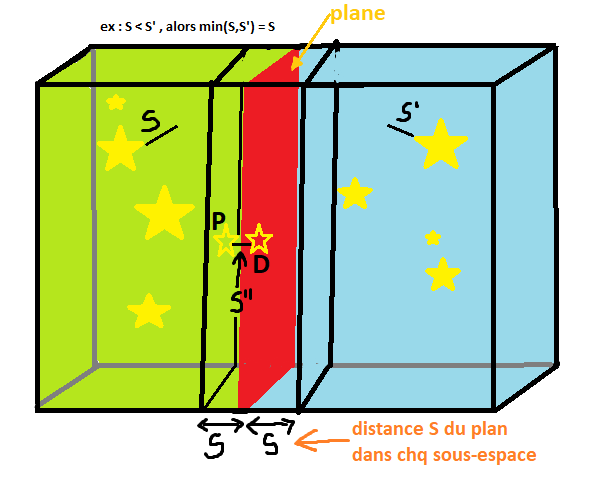


De plus, il est possible que ce dernier sous-espace ( -S | plane | S+ ) contienne un très grand nombre d'étoiles. Sommes-nous tous obligés de les comparer entres elles ? La réponse est heureusement non. Nous pouvons tout simplement répéter le même raisonnement. 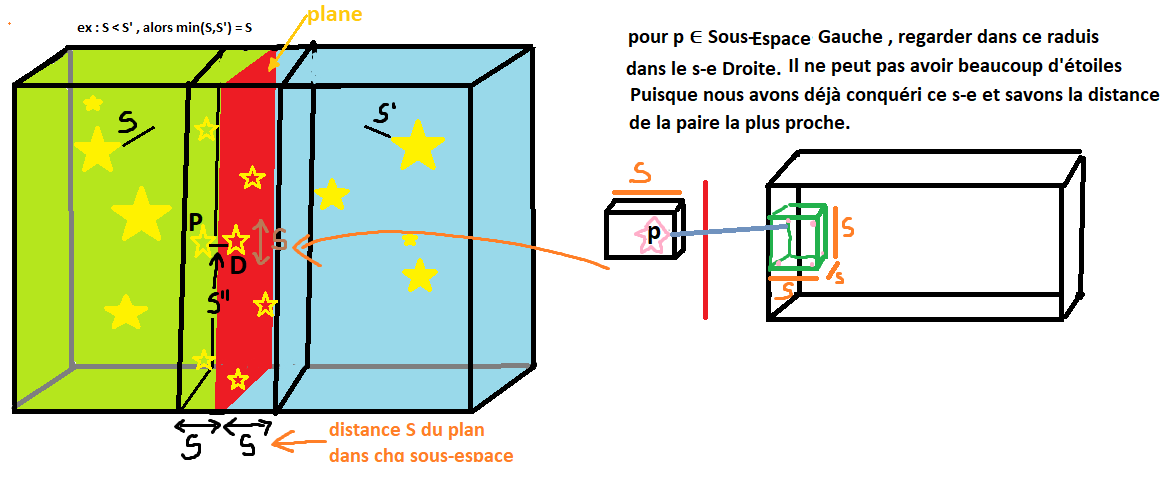

Donc, en parcourant sur l'axe des y cette fois de haut en bas, pour chaque étoile de chacun des deux sous-espace O(n), il suffit de regarder dans le rayon S*S*S (voir image plus haut) O(1) s'il existe une autre étoile. Si oui, alors sa distance vers cette étoile est nécessairement plus petite que ce que nous avions trouvé précedemment et on met donc à jour notre min. 


Faisons ainsi , cet algorithme va retourner pour le serveur la paire la plus proche. Bien entendu , l'optimale pour nous c'est d'en trouver 1000. Il suffit alors tout simplement de garder en mémoire dans un tableau 1000 paires d'étoiles plutôt qu'une seule. 
Autrement dit : 


**TrouverPaire** ( V : [VecteursPositionsÉtoiles_Trié] , Solution : [paires Étoiles] ) : 

    
    1. int D <- ( V[premier Element].getX + V[dernier Element].getX ) / 2 (Possible de deviser mieux qu'au milieu?) 
    
    2. plane <- x = D  
    
    3. Déviser V selon plane
 
    B -> Case de base : ajouter nouvelle paire plus proche points des deux-sous plans à [Solution] si : 
        
        length ( Solution ) < 1000  ou nouvelle paire < toutes les paires dans Solution 
        Note : supprimer paire avec plus grand distance si len(Solution) > 1000 avec l'ajout
        
    R -> Récursivement deviser les deux sous-espaces. 



Si nous faisons cela pour tous nos serveurs parallelement et on assumons que ca marche, alors chacun de nos serveurs aura trouver 1000 paires d'étoiles les plus proches. Rapidement comme ca , on peut se dire que cela ne nous pas avancé de beaucoup puisque 1000 paires d'étoiles pour chaque serveurs , on se retrouve à 1000 * 1200 = 12 000000 paires d'étoiles. Pourtant cela nous oeuvre une piste pour la puiste puisque nous allons probablement re utiliser ces 1000 * 1200 paires trouvées. 

Prenons le temps de regarder cette image de la dernière démo : 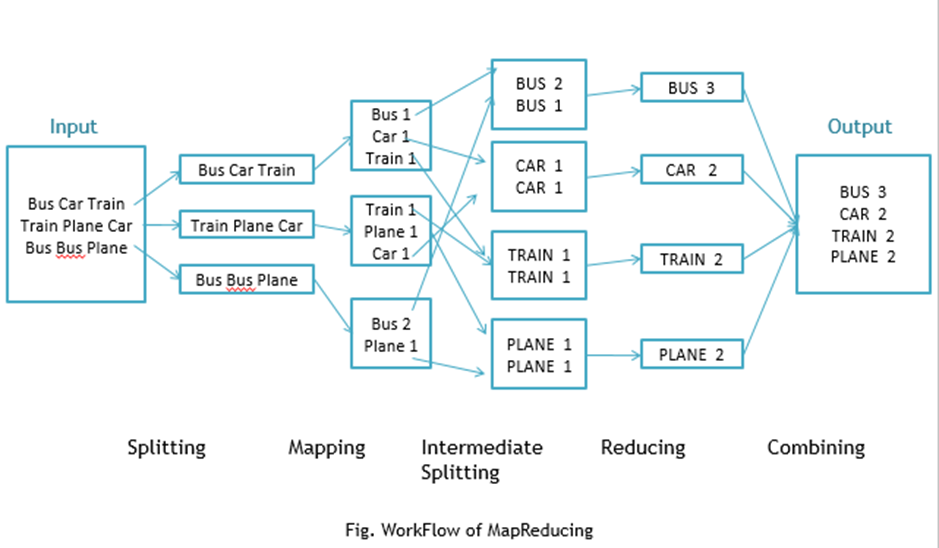

Il est clair que le input et le splitting a déjà était fait sur nos serveurs. Cela dit pour le reste pas encore. Mais avant de sauter au code, voyons les choses comme suit: 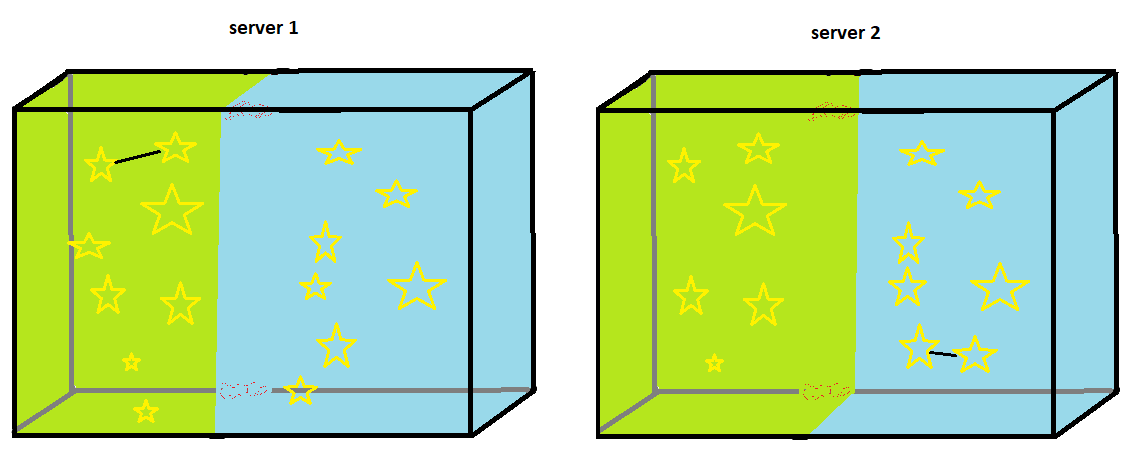

Ca ne vous rappel pas quelque chose? Oui ca nous rappel notre espace que nous avions séparés en deux. Maintenant la différence, c'est que nous avions deux sous-espace , mais disons pas exactement séparés comme on le shouaite. Bien-sûr nous savions pour chacuns des deux serveurs séparement quelles sont les 1000 meilleures paires. Mais est ce qu'on peut appliquer le même raisonnement aux deux serveurs aditionnés ensemble? Oui : 

**Algo**( V1 : Server1[Étoiles] , V2 : Server[Étoiles] 
    
    1. V <- V1 + V2 
    2. trouverPaire(V.trié() ,S) 
    3. return S 

Le problème majeur étant que pour éviter de manquer des paires et être sûr que nous avons vu toutes les possiblités , nous devions pas seulement comparer deux serveurs entre eux, mais dans notre cas 1200 serveurs entre eux un à un! On va pas calculer combien ,mais cela va prendre beaucoup trop de temps. 

On revient à notre problème initiale dans laquelle on ne voulait pas comparer les étoiles une à une. Là si on compare les serveur un à un, on n'a pas avancé. 


   
 

### Algo final 

Y'a-t-il un moyen d'optimiser ? Encore une fois et heureusement oui! 


Vous vous rappelez qu'on avait parler plus tôt de tri. Bien c'est maintenant de sortir le grand jeu. Nous allons enfin proposer notre algorithme final qui est en deux étapes: 

    1. Trier nos serveurs tous parallèlement O(n) (Nouveau**) 
    
    2. Comparer un serveur seulement à ses max(1,2) serveurs adjacents dans un rayon de min(S,S'). (À mettre en contexte)
    
  
Biensûre c'est encore flou et quelques explications plus claires s'imposent. 

#### Trier nos serveurs tous parallèlement O(n)   


Nous avons 1200 serveurs à trier. En réalité le nombre de serveur n'est pas important. Nous allons dire pour le moment k serveurs. 

Utilisons un premier map reduce sur tous nos serveur pour calculer le point le plus petit dans tous les serveurs. Un point est  représenté par un vecteur (x,y,z) , donc nous voulouns par priorité : le x le plus petit. Ensuite , le y le plus petit possible. Enfin,le z le plus petit possible. On trouve au même temps le point maximum. (plus grand x, ensuite y  , ensuite z).

Par exemple dans { (4,6,7) (2,9,7) (3,9,3) (2,1,9) (9,2,1)} , le max est (9,2,1) et le min est (2,1,9). 

Cela est vraiment utile , puisque nous allons savoir notre frontière à gauche et à droite sur l'axe X 
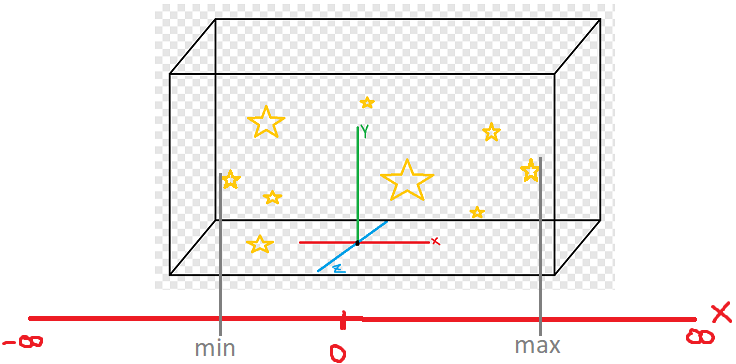

Pour procéder c'est simple, on parcours chaque étoile O(n) de chacun des serveur parallèlement et en garde en mémoire le min et le max de chaque serveur. Ensuite on compare tous les min et tous les max. et on garde le Min de tous les mins trouvés et le Max de tous les max trouvés. 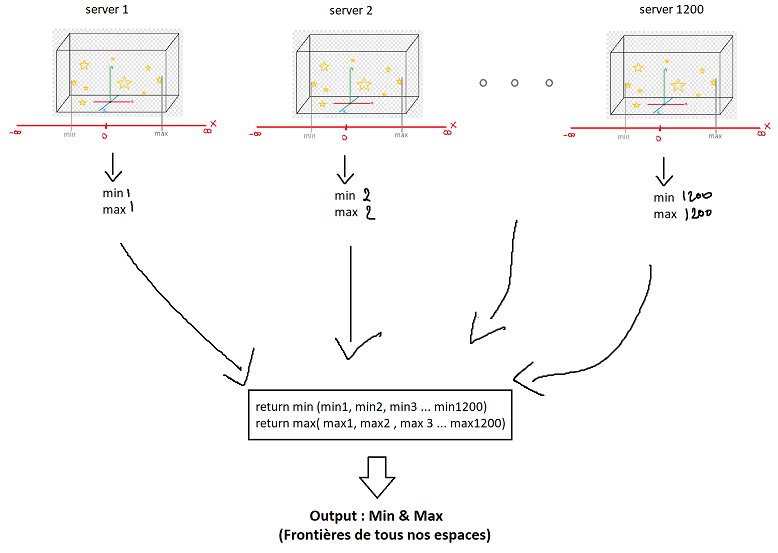

Maintenant , il suffit de trouver où deviser notre espace sur l'axe des x. Nous devons biensûre le deviser k fois (soit 1200 fois dans notre cas). Puisque maintenant nous avons le min et le max, ca simplie le choses. Il suffit de faire: 

Taille d'une intervalle = ( Max - Min ) / k 

Donc, nous allons avoir k - 1 séparateur à poser : 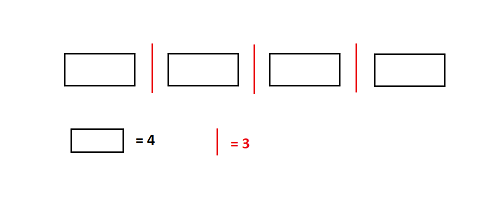

et chaque serveur représenter une intervalle.  

    1. Server 1 : min --> min + intervalle 
    2. Server 2 : min + intervalle -> min + intervalle * 2 
    3. ...
    4. Server 1200: min + intervalle * 1199 -> max 

Bon, maintenant que nous savons tout ca , on peut tout simplement déviser notre espace 3D sur l'axe des x à travers nos 1200 serveurs. De plus, avec un peu d'algèbre, on peut savoir pour chaque points dans n'importe quel serveur dans quel serveur il deverait appartenir.  

Maintenant une remarque très importante. Pour que cela marche , il est nécessaire de rappeler que chacun de nos serveurs a environ 80% d'espace libre. De plus, nous allons assumer que nos données sont répartis de manière uniforme. En effet, il n'y a pas de raison pour laquelle il y'ait beaucoup plus (>100%) d'étoiles d'une intervalle plutôt que dans une autre.

Voilà comment nous allons procéder : 

Nous allons lire les tables d'étoiles de chacun de nos serveurs en parallèle. Pour chaque position d'étoile dans chaque serveur O(n), s'assurer que l'étoile en question est dans la bonne intervalle O(1). Si oui , alors ne rien faire. Si non, alors d'abord la transférer dans le serveur avec la bonne intervalle et la supprimer du mauvais serveur. 


Bon maintenant que tous nos serveurs sont triés, nous sommes beaucoup plus avancé qu'au départ. Rappelons que pour le moment, nous avons traverser toutes nos données seulement deux fois. Soit deux lectures en parallèles. Et aussi, nous avons déplacés nos étoiles. Dans le pire cas, disons que nous avons déplacer toutes nos étoiles (750 GO). Cela est très peu probable, mais assumons le pire. 


### Comparer chaque serveur seulement aux serveurs adjacents


Bon, nos serveurs sont triés, mais nous n'avons pas encore terminés. D'abord, appliquons notre fameux algorithme **TrouverPaire([Étoiles] , S)** que nous avions expliqué beaucoup plus haut et qui fonctionne en O(n log n). Cet algorithme prend en argument notre table d'étoiles (leurs vecteurs positions) préablement triée en O(n log n), et retourne S qui est une liste des paires des étoiles les plus proches dans le serveurs. 

Biensûre , tous les serveurs peuvent appliquer cet algorithme en même temps O(n log n). Et Écrire les paires d'étoiles (S) au même temps qu'elles sont trouvées. Donc au final, pour chaque serveur, donc chaque intervalle de x, nous savons quelles sont les paires d'étoiles les plus proches.

Mais biensûre, on se retrouve face à un problème que nous avons déjà discuté précedemment.  Et si nous avons un serveur A avec comme distance la plus proche S et un serveur B avec distance S'. Alors la distance minimale trouvée est min(S,S'). Il est possible qu'il existe une étoile a ∈ A et une étoile b ∈ B tel que distance(a,b) < min(S,S'). Pour éviter ce problème, il est impératif de comparer les étoiles du serveur A aux étoiles de serveur B. Nous avions biensûre trouver une solution qui marche en O(n) et qui consiste à traverser chaque étoile dans une distance de min(S,S') de la frontière et de regarder dans le bon raduis O(1). Si on trouve une étoile, alors on met à jour notre nos paires. 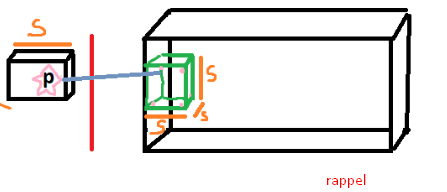

Maintenant, pour chacuns de nos serveurs  , il suffit de regarder les serveur adjacents. 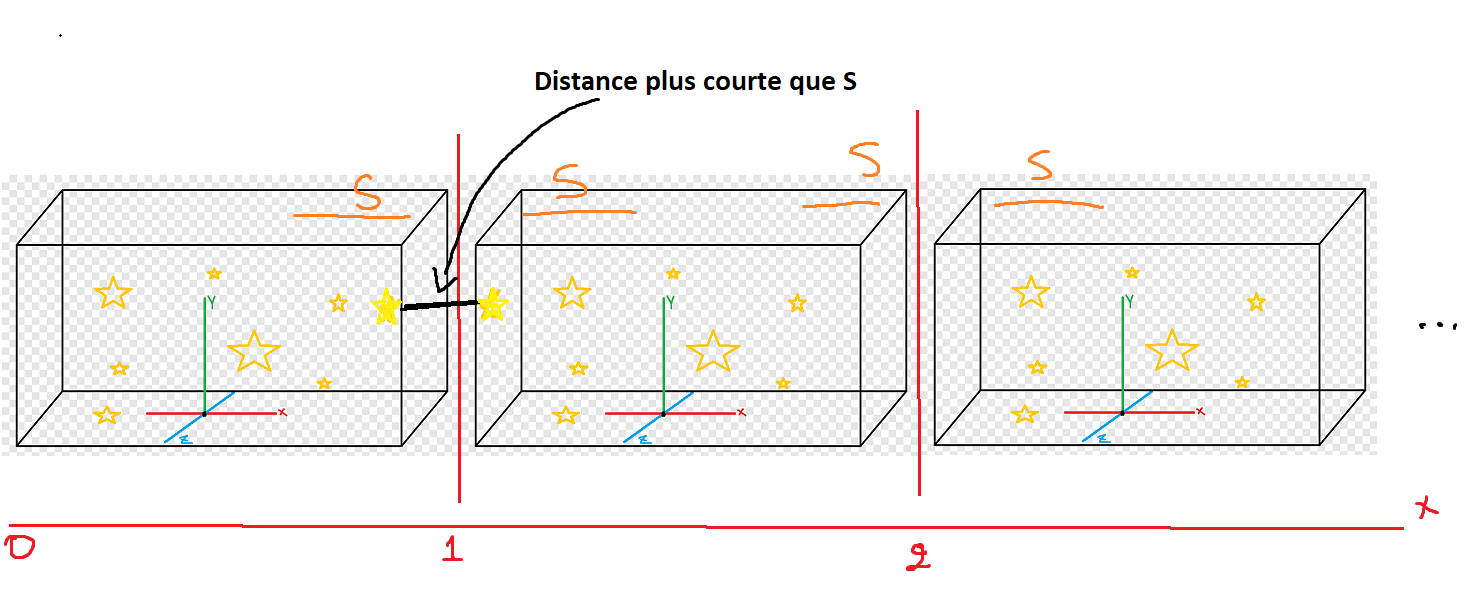

Donc, bref au lieu de comparer toutes les étoiles d'un serveur à tous les autres serveurs. Chaque serveur est seulement comparé à au plus deux serveurs. Sinon à un seul serveur s'il s'agit du serveur 0 ou du serveur 1200. De plus, la beauté de l'algorithme est que nous comparons pas toutes les étoiles d'un serveur à celles d'un autre. On fait comme expliqué précedemment, on parcours les étoiles à une distance minimale de la frontière. Et on regarde dans un certains rayon dans le 2ème serveur pour voir si on peut trouver de mieux paires que ce que nous avons déjà. 

Biensûre, tous cela peut-etre fait en parallèle. On se concentre sur les serveurs au milieu , soit tous les serveurs sauf 0 et 1200. Donc sur les 1200-2 = 1198 serveurs. Si chaque serveur communique avec deux serveurs. Alors chaque serveur qui envoie et recoit des informations à une vitesse de 1Go par seconde. Et puisque nous allons assumer que nous données sont encore distribuées de manière balancées (soit 750Go par serveur). Alors , dans le pire des pires cas. On doit communiquer ces 750 Go à deux serveurs. Et recevoir 750Go depuis 2 seveurs. Ce qui devise notre rapidité 1Go/sec par 4. Donc 250 Mo par seconde. 

Il est juste important pour éviter toute erreur que chaque serveur conserve deux copies de paires lors des transactions de données puisqu'il est possible d'avoir des chauvechements. Mais dans dans les cas, le résultat sera que chaque serveur conserve uniquement les meilleures paires. 

À la fin on se retrouve avec 1000 paires par serveurs. Ces 1000 paires sont garentis d'être les meilleures possibles dans ces sous-espaces locaux. Aucune paires n'est écartée. 


Maintenant, il faut comme on avait faire pour min/max et garder les meilleures paires uniquement pour chaque serveurs. Nous avons 1000 * 1200 paires. Nous en voulouns seulement 1000. 

Il suffit simplement de faire combattre les serveurs entre eux et garder les meilleures paires. Comme un genre de tournoi. 
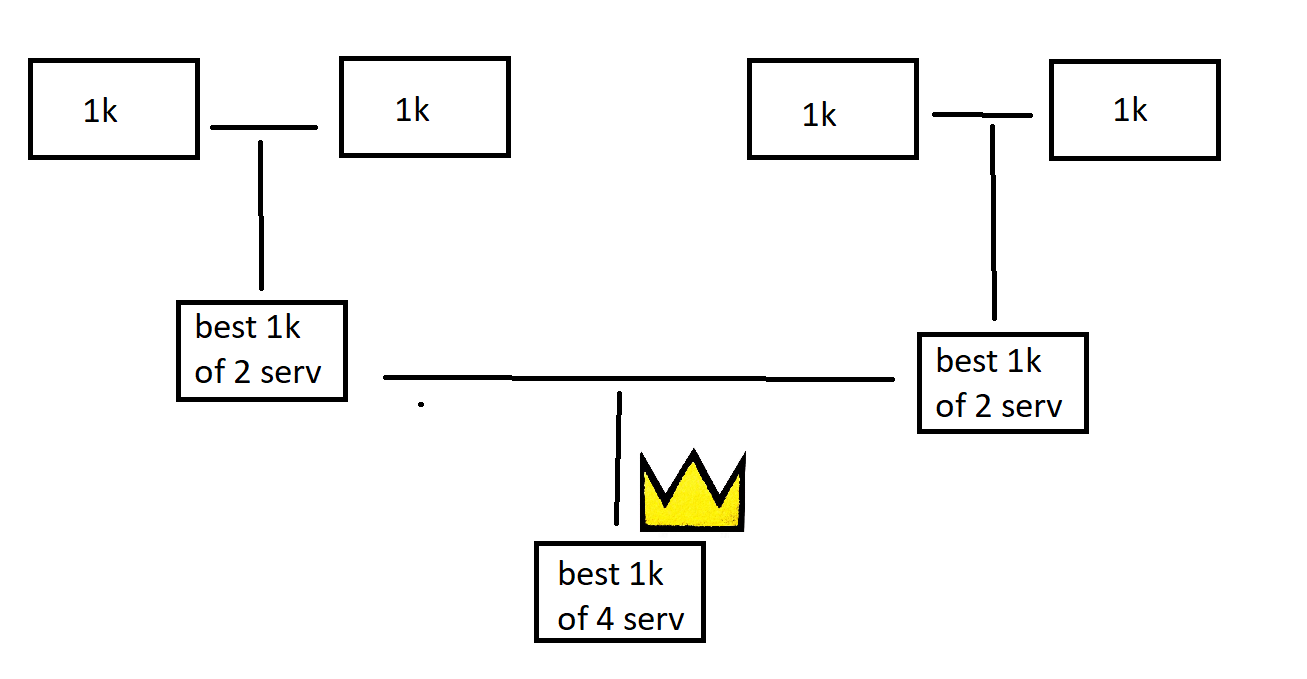

Donc, il suffit simplement de bien faire notre "tournoie". En effet, il est important qu'un maximum de serveurs soit comparés parallèlement au même temps. Si on devise tout simplement par deux, ca ne marchera pas, puisque 1200 n'est pas une puissance de deux. La solution c'est d'essayer de créer un arbre pour s'assurer de tirer un maximum de profit de notre parallélisme. 

En d'autres mots, il est important que des serveurs qui ont "finis leur travail" n'attendent pas trop longtemps avant d'êtres comparés à d'autres serveurs qui n'ont pas encore finit. Si on devise nos compraisons comme suit, l'attente est réduite au maximum puisque le résultat de très peu de serveurs va se terminer beaucoup plus tôt que la plupart des serveurs qui eux vont tous se terminer au même temps et en harmonie. 

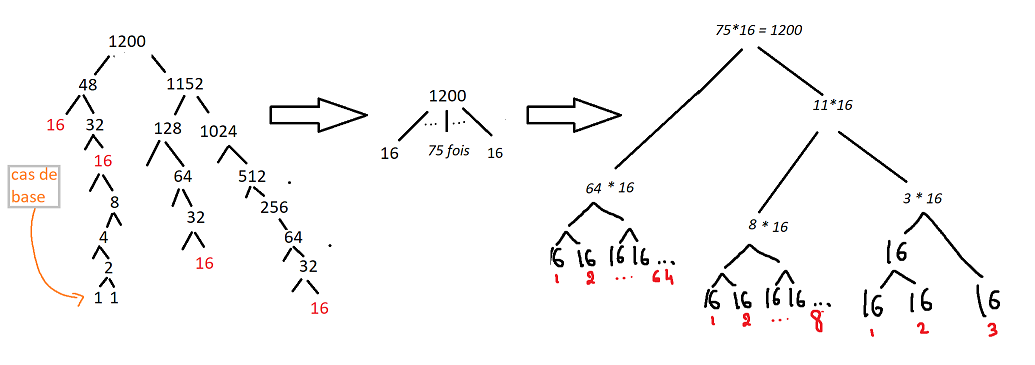


Bref. Notre algorithme final est un mélange de tout ce qu'on a disucté précedemment. Il faut retenir qu'il est meilleur qu'un algorithme naif puisque dans un algorithme naif on aurait comparés tous les serveurs un à un. Alors que dans notre cas, on devise pour conquérir O(n log n) et quasi toutes nos compraisons au même niveau de l'arbre (duel du tournoie) se passent en parallèle. 

Note : Puisque lors de la compraisons on est obliger de recopier une partie du contenu ( meilleures paires, étoiles proche de la frontière) d'un serveur A à celui d'un serveur B (ou vice versa) il est important de gérer l'espace du disque dur et de supprimer ce qui ne va pas être utilisé pour la suite pour être d'avoir toujours assez d'espace pour les futures compraisons. 

**Algo Final** :
        
    1. Obtenir min , max de nos serveurs 
    2. Trier tous nos serveurs sur l'axe des X 
    3. Obtenir parallèlement les paires des plus proches étoiles dans chaque serveurs.
    4. Comparer sur un petit rayon des serveur adjcents pour voir si on peut trouver mieux.  
    5. Obtenir les 1k meilleures paires parmis toutes celles retenues après avoir créer un tree qui maximise le parallèlisme

Conclusion, notre algorithme reste en pire cas en O(n log n). Puisque dans tous nos calculs, nous avions soit parcourus nos données en O(n) ou en O(n log n). Donc même si on fait n * constante , et nlog(n) * constante , cela n'a pas d'importance puisque c'est des constantes et le pire cas possible restera O(nlogn). 

### A. Méthode alternative beaucoup plus simple


Nous savons qu'un algorithme qui prend en argument une table d'étoiles (pour être plus précis les positions des étoiles en x,y,z) retourne les 1000 paires les plus proches d'étoiles en O(n log n). 


Nous utiliser cet algorithme comme une boîte noire. 
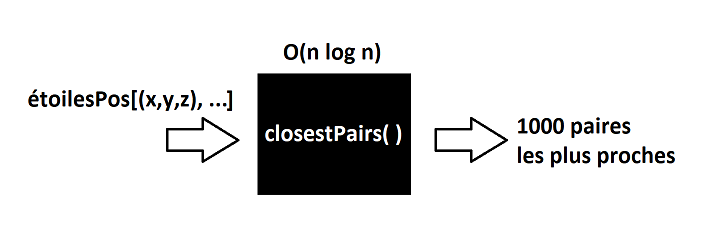


Puisque les étoiles dans nos serveurs ne sont pas triées , il est possible qu'il existe une étoile a dans un serveur A , et une étoile b dans un serveur B , tel que la distance de la paire(a,b) est plus petite que les meilleures paires trouvées par l'algorithme dans le serveur A et le serveur B sépéarement. En effet, le seul moyen de trouver cette paire(a,b) et d'utiliser l'algorithme sur A+B. 

Le défi étant ici qu'il existe pas deux serveurs, mais 1200. Et il faut comparer tous ces serveurs là un à un pour être sûr de manquer aucune paire. Évidemment, nous sommes limités par la puissance de notre serveur (Capacité, vitesse de lecture etc). 

La question est alors : Quel est la méthode la plus rapide pour comparer tous nos serveurs un à un tout en respectant la capacité de nos serveurs. 

Nous avons penser à un algorithme simple que nous alons prendre le temps d'expliquer. 


#### Mise en contexte 

Bon, avant de rentrer dans les détails , expliquons l'essence de notre idée. Ademttons que nous avons un certains nombre de serveurs. pour illustrer disons 4. Donc, nous avons les serveurs {1,2,3,4} et chacun de nos serveur contient une table d'étoiles. Biensûre en parallèle , tous les serveurs peuvent appliquer closestPairs(). 

Cela dit , comme nous avions expliqué, ce n'est pas suffisant, il faut comparer les serveurs un à un aussi. Donc, pour le moment concentrons nous sur le serveur 1. Donc, nous voulons rouler closestPairs(1) , mais aussi closestPairs(1+2), closestPairs(1+3) et enfin closestPairs(1+4). 

L'idée que nous avons eu était de faire circuler la table de manière circulaire. Donc : 

    1. Premier  temps : closestPairs() sur la table i de chaque serveur i en parallèle ( où i ∈ {1,2,3,4} )
    
    2. Deuxième temps : Envoyer la table 1 dans le serveur 2 
    
    3. Troisième temps : rouler closestPairs(table1 + table2) et biensûre on garde les meilleures paires
    
    3. Troisième temps : On commence à envoyer la table 1 au serveur 3 
    
    4. Quatrième temps : On supprime la table 1 du serveur 2 lorsqu'elle a fini d'être copié au serveur 3
     
    5. On recommence ce qu'on a fait plus haut ( soit cloestPairs(table 1 + table3) et ainsi de suite ... )

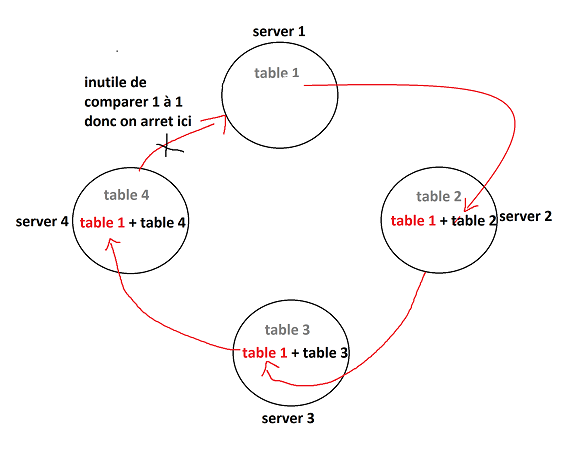
    
    
**Bref, nous avons réussi à comparer la table 1 à toutes les autres! Maintenant dans chacun de nos serveurs on ne manque pas les meilleures paires entre le serveur actuel i et le serveur 1. Pouvons-nous généraliser ?** 


#### Le cercle 


La réponse à la question précédence est oui. D'abord, puisque nous prenons toujours le temps d'effacer les tables, on est sûr de ne jamais saturer la capacités de nos serveurs. Aussi, là on a fait circuler la table du serveur 1 dans les autres serveur, mais rien nous ne empêche de faire circuler toutes les autres tables au même temps. Autrement dit , lorsque le serveur 1 envoie sa table au serveur 2, parallèlement le serveur 2 peut envoyer sa table au serveur 3 et ainsi de suite.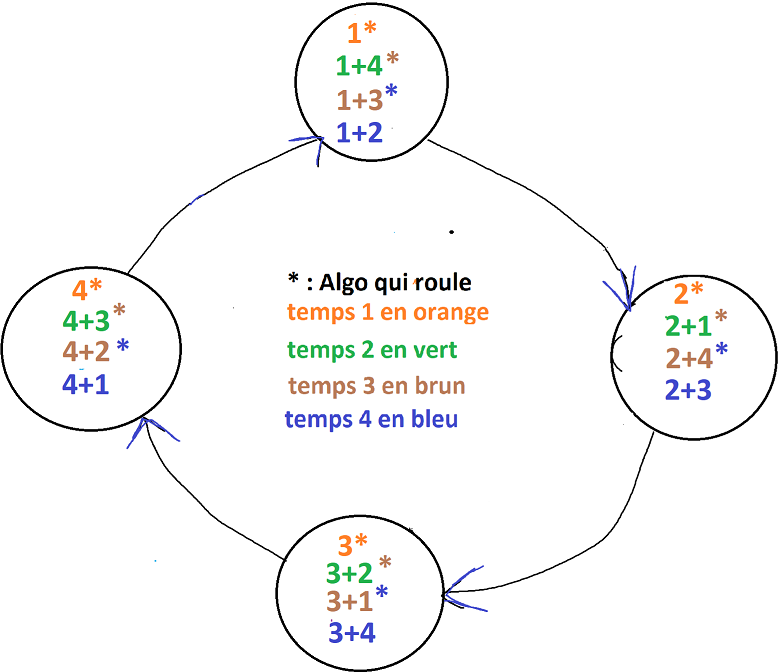


    
On remarque rapidement que nous avons réussi! Chaque serveur est comparé à tous les autres serveurs. On remarque aussi que ca nous prend 3 temps pour faire circuler chaque table d'un bout à l'autre. Ce qui est logique puisque il y a 4 serveurs et donc 4-1 arcs à traverser si on veut faire le tour sans revenir à la case départ. Peut-t-on faire mieux ? 


#### Deux sens 

Et si plutôt que chaque server envoyoie sa table dans la même direction du cercle, chaque serveur envoie sa table dans les deux directions opposées. Illustrons d'abord avec un seul serveur: 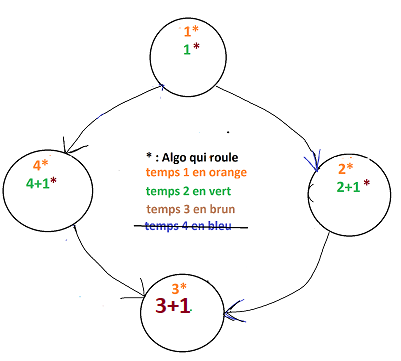

Avant ca nous prenait 3 temps pour circuler la table 1 sur tous les autres serveurs, mainteant ca nous prend seulement 2 temps,  ce qui est mieux. Bon maintenant les choses sérieuses, cela donne quoi si on déplace tout en parallèle?
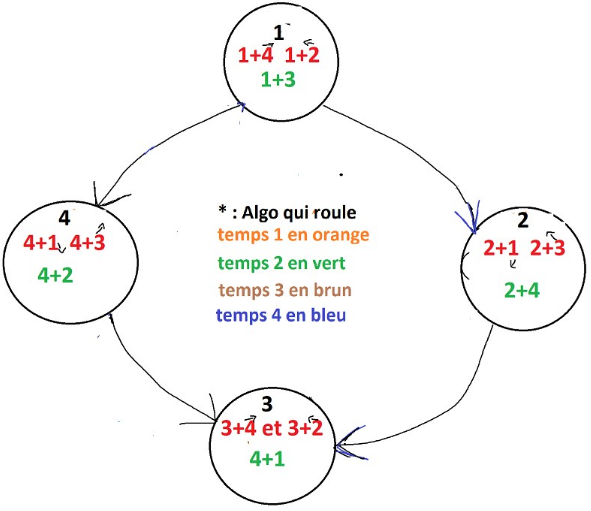

J'ai tout calculer visuellement sur paint et j'ai pu généraliser. En effet, s'il existe k serveurs. Alors avec cette méthode, ca prend k/2 temps pour faire circuler tous les serveurs d'un bout à l'autre. Si k est impair alors on prend le plancher de k/2 et tout fonctionne à merveil. 

Bon maintenant, il reste une chose importante. Si on dit pas à nos serveurs quand arrêter de faire circuler une table, cela risque de tourner à l'infini ? Oui. Donc on propose d'en plus passer la table en question , on passe aussi une variable *pass = int ( k/2 )* et à chaque fois avant de passer la table on fait -1. Et quand *pass == 0* alors on arrêt de faire circuler la table. Ainsi, on est sûr que notre table ne va pas circuler plus que nécessaire. 


#### Les détails techniques 


Pour illustrer en "temps" abstraits et avec des images c'était simple. Mais combien de temps ca prend réellement ? Et surtout comment fonctionne l'algorithme réellement ? 


D'abord , nous savons que nous avons 1200 serveurs. Dans chaque serveur i (où i compris entre 1 et 1200) , il y'a une table Ti. Cette table, comme nous avons conclus précédemment, doit circuler int(1200/2) fois, soit *pass = 600* dans chaque serveur. 

1. La première étape est de rouler notre algorithme une première fois sur chacun de nos serveur en parallèle closestPairs(Ti) 

Biensûre, pour appliquer l'algorithme, il faut d'abord read(Ti), ce qui prend  750Go * / 3Go/s = 250 secondes. Et donc vu que nous devons calculer O(n log n), 250 secondes * log(250) = 600 secondes. Donc 10 minutes.  Ps : 750Go est la taille de la table dans chaque serveur : *( ( 900 Tera * 1000) GO / 1200 Serveurs)*

En appliquant l'algorithme, on écrit une array de 1000 paires d'étoiles , soit une array de 1200 (double, double, double). Donc , 28 800 bytes. Évidemment, notre vitesse d'écriture est très puissante et écris ca instantanément. 

1. Aussi au même temps qu'on lit notre table, chaque serveur envoie sa table à ses deux  serveurs adjacents (qui eux aussi sont occupés à envoyer leurs tables puisque tout est en parallèles). 

D'abord on envoie pas seulement la table, mais un tuple *(pass, Table i)* pour savoir combien de fois chaque table est passée. Aussi, puisque la vitesse de communcation entre les serveurs est de 1Go par seconde, cette vitesse doit être dévisée par 4 puisque chaque serveur envoie sa table à deux serveurs et chaque serveur recoit une nouvelle table de deux autres serveurs. Donc , la vitesse est de 250Mo/s. Puisque nous avons 750Go à déplacer, donc cela nous prend 3000 secondes, soit 50 minutes. 


2. Après chaque fin de communication, on read les nouvelles tables pour appliquer closestPairs( Ti + _ ) . Donc chaque serveur doit appliquer l'algo sur sa propre table + la table recu du serveur à gauche. Aussi sur son algo + table recu de la droite. 

Biensûre, puisque nous devons read(750Go * 2 * 2)  , cela va prendre 3000Go/ 3Go/s = 1000 secondes. Donc en O(n log n), 1000* log (1000) = 3000 secondes. Soit 50 minutes. Au même temps,  l'algorithme met à jour instantanément nos 1000 meilleures paires. 

2. Lorsque nous sommes en train de lires les tables, nous pouvons déjà commencer à transférer les table (50 minutes).

Puisque on le fait en parallèle (heureusement) les temps ne s'additionne pas. Donc seulement 50 minutes pour l'étape 2.



3. Une fois les tables transéférées , on doit les delete des anciens serveurs pour faire de la place à de nouvelles tables. 

On veut supprimer 750Go * 2 , ce qui se fait en 500 secondes. Soit 8 minutes. On ne fait pas cette étape en parallèle puisque ca va revenir au même, vu qu'on va ralentir l'écriture des nouvelles tables. 



**Biensûre, on répète les étapes 2 et 3 jusqu'à ce que chaque table aura traverser 600 serveurs (donc tous les pass==0).**

Au niveau du temps, cela donne : 50 minutes +  599 * (50 minutes + 8 minutes)  = 34 782 minutes. Donc environ 24 jours. Ce qui est moins que 30 jours. 

    
    




### **B.** Compter combien d'étoiles il y a dans chaque catégorie.


##### Mise en contexte

*Énoncé : Pour chaque étoile la table contient ... et sa catégorie représentée par un entier entre 1 et 10 (1 INT8). Nous avons 7300 milliards d’étoiles au total répartis à travers 1400 serveurs.* 

Donc, nous avons environ 5 milliards d'étoiles dans chaque serveur. Chaque entrée dans la table dans un serveur représente une étoile. Et pour chaque entrée la même colonne donne la catégorie de l'étoile.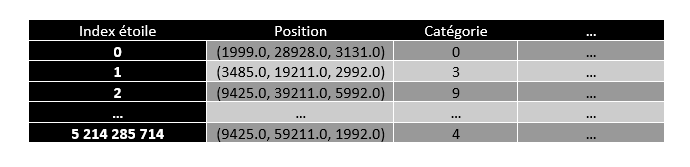

Nous savons d'ailleurs que les données (les tables) sont déjà assignées aux serveurs. 

#### Étape 1 

La taille de chaque table comme discuté précédemment est de **750 GO** calculé avec *((900 Tera * 1000) GO / 1200 Serveurs)*.
Il suffit d'une lecture en O(n) sur un serveur pour savoir il y'a combien d'étoiles dans chacune des catégories avec un algorithme comme le suivant: 

**CompterCatégories(Table[étoiles]):**

    S = initializes array of length 10 filled with 0's 

    for étoile in Table[Étoiles]: 
        S [toile.getCatégorie] += 1 
        
    return S

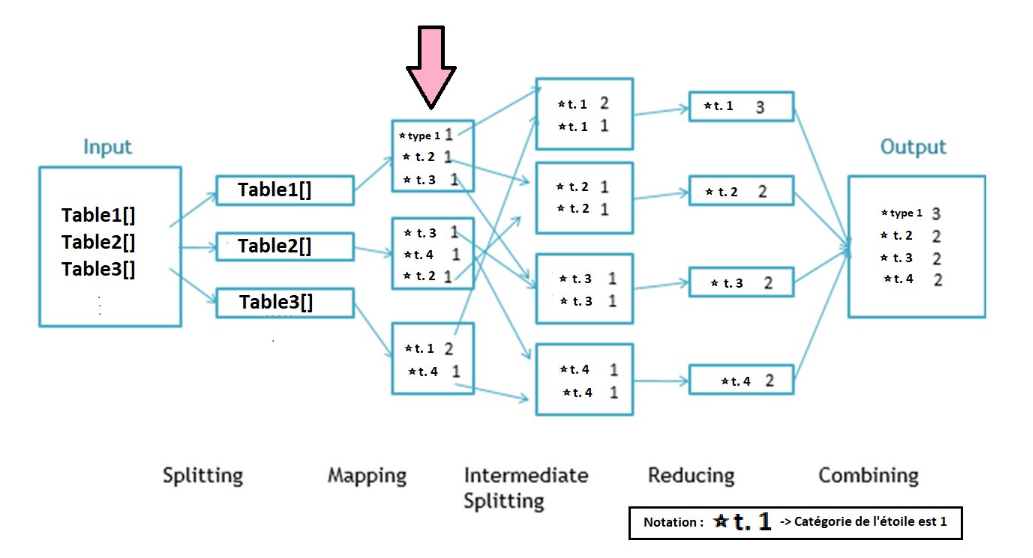

Ainsi, à la fin de notre calcul en parallèle , chaque serveur aura une array d'une taille de 10 int. Chaque élément dans ce tableau peut être lu comme suit : S[0]=(étoile de catégorie 0 , nombre d'étoiles de type 0) , ... , S[i] (Étoile de Catégorie i, # d'étoiles de catégorie i). 

le temps estimé pour cette étape est de O(n) puisque nous allons lire les n entrées de la table de tous les serveurs parallèlement. Ce qui risque de prendre le plus de temps est probablement la lecture des données. On va assumer que notre algorithme est vraiment naif et lit chaque entrée au complet au lieu de lire simplement les catégories. Donc, pour lire toutes les entrées (750GO) nous avons besoin de 750GO/ 3Go par seconde = **250 secondes**. Soit 4 minutes environ. Enfin, l'écriture se fait au même temps que la lecture et nous allons assumer que l'écriture dans le tableau S se fait instanténement dans chaque serveur puisque nous devons écrire un int dans un tableau de taille 10 à chaque fois et vu notre vitesse d'éciture ce n'est vraiment pas un problème. 

#### Étape 2 
Puisque nous avons 1200 serveurs, donc 1200 arrays S. Il faut faire la somme de toutes ces arrays pour avoir le nombre d'étoiles pour chaque catégories dans tous les serveurs réunis. Nous allons proposer une approche simple à comprendre et qui sera toute de même efficace vu la petite taille de données qu'on va manipuler dans notre cas. 

Nous allons utiliser 10 serveurs arbitraires. Vu que nous avons 1200 serveurs et 10 catégories d'étoiles, faisons simple et utilisons les 10 premiers serveurs. Soit le serveur 1, 2, 3, 4, 5, 6, 7, 8, 9, 10. 

Le serveur 1 va recevoir l'information dans S[0] (soit le nombre d'étoiles dans la catégorie 1) de tous les autres serveurs. 
...
Le serveur 10 va recevoir l'information dans S[9] (soit le nombre d'étoiles dans la catégorie 10) de tous les autres serveurs. 


Maintenant, il est intéressant de se demander combien de temps cette étape va prendre ? Nous savons que les serveurs peuvent communiquer entre eux à une vitesse de 1Go/sec. Nous allons assumer que nous avons pour chaque serveur une vitesse de 1Go/s de download et 1Go/s de upload. Puisque les 10 premiers serveurs vont recevoir à la fois des informations de tous les autres serveurs , leurs vitesse de download sera dévisées. 


Le serveur 1 va recevoir de l'information de 1200 serveur (on va l'inclure lui-même , cela ne change pas grand chose) au même temps. Il ne peut que télécharger 1Go à la fois. Cela dit, quand on y'pense objectivement, le serveur 1 va recevoir 1200 valeurs de type int. En informatique, nous savons qu'un int peut être représenté avec 4 bytes. Donc nous avons 4 * 1200 bytes. Soit 4800 bytes. Donc, en réalité le serveur 1 va devoir télécharger 4,8 Kilobyte. Vu notre vitesse de téléchargement , nous allons assumer que c'est instantané. 

Qu'en-t-il du côté de l'upload ? Chaque serveur doit envoyer 10 int (son tableau S) aux 10 premiers serveurs. Encore une fois, 10 int c'est seulement 40 bytes. Nous allons assumer direcetement que c'est instantané. Nos serveurs sont beaucoup trop puissants. 

Donc on résume, dans les 10 premiers serveurs, chaque serveur i va créer une nouvelle variable *Catégorie i* de type int qui sera initialisé avec sa propre valeur S[i-1] (Ex Serveur 1 : Catégorie_1 = S[0]). Ensuite , ce serveur va recevoir de tous les autres serveurs des ints et va simplement les aditionner à cette variable. Biensûre , puisqu'il va recevoir toutes les int au même temps, il serait plus sucéritaire de créer une file Buffer = [] , dans laquelle on ajoute toutes les ints avant de les ajouter un par un à Catégorie_1. Mais si on fait cela, ca ne va pas impacter notre temps. 
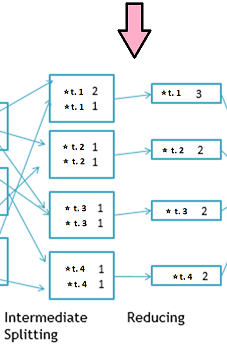

#### Étape 3 

Maintenant que chacuns de nos 10 premiers serveurs contient une donnée (du tableau) , nous voulouns les combiner dans un seul tableau. Bref, nous avons 10 données, nous voulons un tableau de taille 10. La manière la plus simple est de créer un tableau dans le serveur 1. *CatégoriesComptés = []*. Ensuite, on peut déjà mettre dedans la variable *Catégorie_1* comme suit *CatégoriesComptés.append(Catégorie_1)*. Maintenant il suffit que nos 9 autres serveurs envoie leur données *Catégorie_i* et chacunes des données va être append au tableau comme suit *CatégoriesComptés.append(Catégorie_i)*. Bref à la fin , ce tableau est notre réponse finale. Soit la somme totale de toutes les catégories. Encore une fois tout cela prend seulement quelques secondes (instantané) puisqu'il suffit de déplacer une très petite quantitée d'informations au serveur 1. 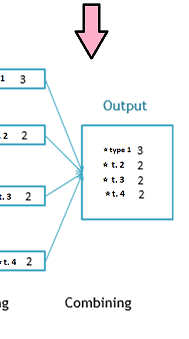


**Tout cela nous aura pris moins de 5 minutes.**



⠀

### **C.** Produisez un classifieur qui, étant donné le vecteur de caractéristiques (23 nombres réels), prédit la catégorie de l’étoile. Il est important que votre classifieur utilise une technique de calcul distribué soit pendant l’entraînement et/ou lors de la prédiction.


Soit un classifieur donné, comment s'y prendre pour prédire la catégorie d'une étoile suite un entrainement sur ses caractéristiques. 

Rappel de la démo 2 : *X_train, X_test, y_train, y_test* 

Ici, nous allons plus nous concentrer sur la partie entrainêment (X_train , y_train). La raison est simple. En effet, plus notre échantillion d'entrainement est grand, plus nos prédictions seront meilleures. 

Tandis que la partie prédiction (X_test, y_test) est moins importante puisqu'elle permet seulement de confirmer si notre modèle est bon. Plus notre échantillion test est grand, mieux on connaintera la qualité de nos prédictions. Cela dit, même avec un échantillion pas très grand, si la qualité de notre modèle est mauvaise on le saura assez vite. 

Bref, il est clair que si la taille totale de **|X_train + X_test| = 100%** , dans ce cas **|X_train| = 70%|** et **|X_test| = 30%|**. 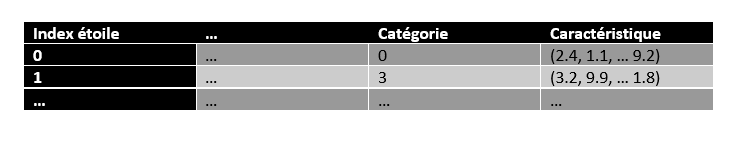

Il est aussi clair que notre colonne catégorie c'est le label (y) et que la colonne caractéristique sont les données sur lesquelles on veut s'entrainer. (Pour faire un parallèle avec Mnist, les chiffres c'est les catégories et les vecteurs pixels sont les vecteurs caractéristiques). 

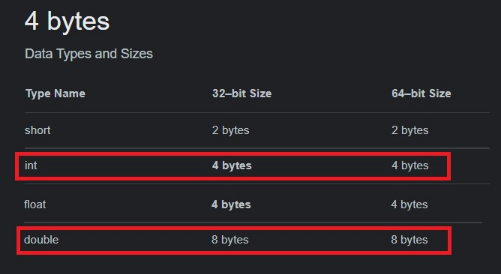

Donc, si nous avons un tuple de ce type : ( catégorie, vecteur de caractéristiques) , soit un (int, [double * 23])
Donc la taille de ce tuple est : 4 bytes + 8 bytes * 23 = 188 bytes. Soit 0,188 kilobyte. 


Idée , faire comme la question 1.A , mais au lieu d'avoir un cercle en avoir plutôt deux. Un qui est grand. 1024 et un autre qui est plus petit 176. On fait circuler l'information exactement de la même manière qu'à la question 1.A. Cette fois ci, au lieu d'appliquer l'algo closestPairs() , on applique plutôt l'algo de notre modèle qui crée la matrice de dissimilarité. 

Biensûre, on passe la matrice de dissimilarité d'un serveur à l'autre pour l'augmenter à chaque fois. À la fin tous nos serveurs auront une matrice de dissimilarité qui aura pris en compte tous les serveur du premier grand cercle un à un. 

Ensuite biensûre, on pourra communiquer notre modèle à l'un des serveur du petit cercle. Et refaire la même méthode pour tester la qualité de notre modèle. 